Now we will use a PINN to solve the inverse problem.

The differential equation we will be solving is:
$$
f' = R(1-t)*t
$$

but this time we don't know what R is and we will use a NN to figure it out


In [1]:
import numpy as np
from torch import nn
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
import itertools

In [2]:
# Data generation
def f_true(t,r,f):
    return f-r*t**3 / 3 + r*t**2/2

In [3]:
N = 10
R = 2
F0 = 1
t_data1 = torch.linspace(-1, 2, steps=N,requires_grad = True).view(-1, 1)
t_data2 = torch.linspace(4, 6, steps=N,requires_grad = True).view(-1, 1)
t_data = torch.concatenate((t_data1,t_data2))

In [4]:

f_data = []
for i in range(len(t_data)):
    t = t_data[i].detach().numpy()
    if t<3:
        R = 2
        F0 = 1
    else:
        R = -1
        F0 = -12.5
    f_data.append( f_true(t , R, F0) )

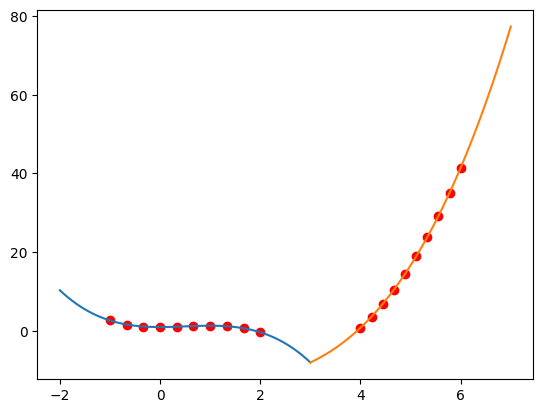

In [5]:
t_data_max = np.linspace(-2,3,100)
plt.plot(t_data.detach().numpy(),f_data,'or')
plt.plot(t_data_max,f_true(t_data_max,2,1))
t_data_max = np.linspace(3,7,100)
plt.plot(t_data_max,f_true(t_data_max,-1,-12.5))

In [6]:
class NNapproximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out

PINN = NNapproximator(2,2)

In [7]:
class Rapproximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
Rapprox = Rapproximator(2,3)

In [8]:
PINN(torch.tensor([[1.0],[1.0]]))

tensor([[-0.2706],
        [-0.2706]], grad_fn=<AddmmBackward0>)

In [9]:
Rapprox(torch.tensor([[1.0],[1.0]]))

tensor([[0.2577],
        [0.2577]], grad_fn=<AddmmBackward0>)

In [10]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

In [11]:
def compute_loss(nn,rr,x):
    de_loss = df(nn,x) - rr(x)*x*(1-x)
    bc_loss = f(nn,t_data) - torch.as_tensor(f_data)
    final_loss = de_loss.pow(2).mean() + bc_loss.pow(2).mean()
    return final_loss

In [12]:
def optimise(optimiser,nn,r,x):
    optimiser.zero_grad()
    loss = compute_loss(nn,r,x)
    loss.backward()
    optimiser.step()
    return loss

In [13]:
lr = 0.001
epochs = 100000
PINN = NNapproximator(2,10)
R_approx = Rapproximator(2,3)
learnable_params = list(PINN.parameters()) + list(R_approx.parameters())
pi_optimizer = Adam(learnable_params, lr=lr)

In [20]:
loss_vector = []
iteration_vector =[]
for i in range(epochs):
    loss = optimise(pi_optimizer,PINN,R_approx,t_data)
    if i % 1000==0:
        iteration_vector.append(i)
        loss_vector.append(loss.detach().numpy())
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


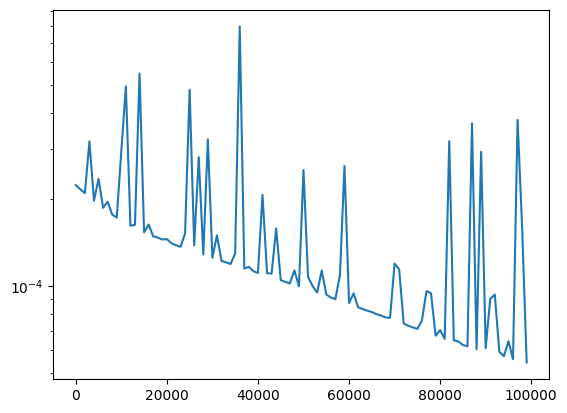

In [21]:
plt.plot(iteration_vector,loss_vector)
plt.yscale('log')

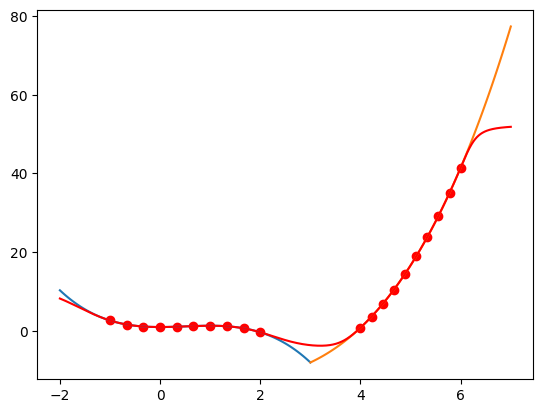

In [22]:
t_data_domain = torch.linspace(-2, 7, steps=1000).view(-1, 1)
with torch.no_grad():
    f_prediction = PINN(t_data_domain).numpy()
    

plt.plot(t_data.detach().numpy(),f_data,'or')

t_data_max = np.linspace(-2,3,100)
plt.plot(t_data_max,f_true(t_data_max,2,1))
t_data_max = np.linspace(3,7,100)
plt.plot(t_data_max,f_true(t_data_max,-1,-12.5))
plt.plot(t_data_domain,f_prediction,'r')

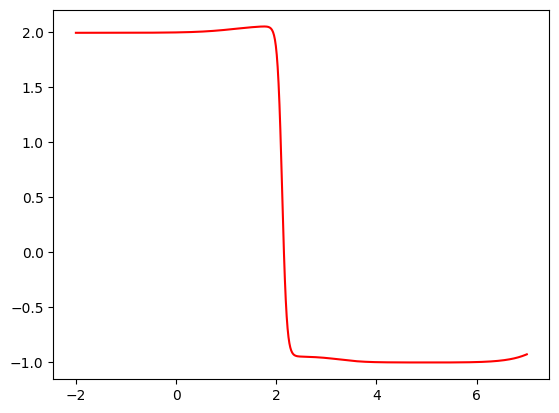

In [23]:
# NOw interrogate the R approximator
t_data_domain = torch.linspace(-2, 7, steps=1000).view(-1, 1)
with torch.no_grad():
    r_prediction = R_approx(t_data_domain).numpy()

plt.plot(t_data_domain,r_prediction,'r')